# Logging with tensorboard

The ``tensorboard`` extension allows to log various information (scalars, images, etc) during training for visualization using `tensorboard`.

It has to be explicitly imported:

In [1]:
from ANNarchy import *
from ANNarchy.extensions.tensorboard import Logger

import matplotlib.pyplot as plt

ANNarchy 4.6 (4.6.9b) on linux (posix). 


As it is just for demonstration purposes, we will be an extremely simplified model of the basal ganglia learning to solve through reinforcement learning a stimulus-response task with 4 stimuli and 2 responses (left and right). The two first stimuli should be responded with left, the two others with right.

In [2]:
stimuli = [
    ([1, 0, 0, 0], 0), # A : left
    ([0, 1, 0, 0], 0), # B : left
    ([0, 0, 1, 0], 1), # C : right
    ([0, 0, 0, 1], 1), # D : right
]

We keep here the model as simple as possible. It is inspired from the rate-coded model described here:

Vitay J, Hamker FH. 2010. A computational model of Basal Ganglia and its role in memory retrieval in rewarded visual memory tasks. Frontiers in computational neuroscience 4. [doi:10.3389/fncom.2010.00013](https://www.frontiersin.org/articles/10.3389/fncom.2010.00013)


The input population is composed of 4 static neurons to represent the inputs:

In [3]:
cortex = Population(4, Neuron(parameters="r=0.0"))

The cortex projects on the striatum, which is composed of 10 neurons integrating excitatory and inhibitory inputs:

In [4]:
msn = Neuron(
    parameters="tau = 10.0 : population; noise = 0.1 : population", 
    equations="""
        tau*dv/dt + v = sum(exc) - sum(inh) + noise * Uniform(-1, 1)
        r = clip(v, 0.0, 1.0)
        """)
striatum = Population(10, msn)

The striatum projects inhibitorily on GPi, whose neurons are tonically active (high baseline). Normally, GPi would project on the thalamus and back to the cortex, but here we read the output of the network directly in GPi: if the first neuron (corresponding to the left action) is less active than the second neuron, the selected action is left.

In [5]:
gp_neuron = Neuron(
    parameters="tau = 10.0 : population; B = 1.0",
    equations="tau*dv/dt + v = B - sum(inh); r= pos(v)")
gpi = Population(2, gp_neuron)

Learning occurs at the cortico-striatal synapses, using a reward-modulated Hebbian learning rule, with Oja regularization:

In [6]:
corticostriatal = Synapse(
    parameters="""
        eta = 0.1 : projection
        alpha = 0.5 : projection
        dopamine = 0.0 : projection""",
    equations="w += eta*(dopamine * pre.r * post.r - alpha*w*post.r*post.r) : min=0.0"
)
cx_str = Projection(cortex, striatum, "exc", corticostriatal)
cx_str.connect_all_to_all(weights=Uniform(0.0, 0.5))

Some lateral competition between the striatal neurons:

In [7]:
str_str = Projection(striatum, striatum, "inh")
str_str.connect_all_to_all(weights=0.6)

One half of the striatal population is connected to the left GPi neuron, the other half to the right neuron:

In [8]:
str_gpi1 = Projection(striatum[:int(striatum.size/2)], gpi[0], 'inh').connect_all_to_all(1.0)
str_gpi2 = Projection(striatum[int(striatum.size/2):], gpi[1], 'inh').connect_all_to_all(1.0)

We add a monitor on GPi and compile:

In [9]:
m = Monitor(gpi, 'r')
compile()

Each trial is very simple: we get a stimulus `x` from the `stimuli` array and a correct response `t`, reset the network for 40 ms, set the input and simulate for 50 ms, observe the activity in GPi to decide what the answer of the network is, provide reward accordingly to the corticostriatal projection and let learn for 10 ms. 

Here the "dopamine" signal is directly the reward (+1 for success, -1 for failure), not the reward prediction error, but it is just for demonstration.

In [10]:
def training_trial(x, t):
    
    # Delay period
    cortex.r = 0.0
    cx_str.dopamine = 0.0
    simulate(40.0)
    
    # Set inputs
    cortex.r = np.array(x)
    simulate(50.0)
    
    # Read output
    output = gpi.r
    answer = np.argmin(output)
    
    # Provide reward
    reward = 1.0 if answer == t else -1.0
    cx_str.dopamine = reward
    simulate(10.0)
    
    # Get recordings
    data = m.get('r')
    
    return reward, data

The whole training procedure will simply iterate over the four stimuli for 100 trials:

```python
for trial in range(100):
    # Get a stimulus
    x, t = stimuli[trial%len(stimuli)]
    # Perform a trial
    reward, data = training_trial(x, t)
```

We use the `Logger` class of the `tensorboard` extension to keep track of various data:

```python
with Logger() as logger:
    for trial in range(100):
        # Get a stimulus
        x, t = stimuli[trial%len(stimuli)]
        # Perform a trial
        reward, data = training_trial(x, t)
        # Log data...
```

Note that it would be equivalent to manually close the Logger after training:

```python
logger = Logger()
for trial in range(100):
    # Get a stimulus
    x, t = stimuli[trial%len(stimuli)]
    # Perform a trial
    reward, data = training_trial(x, t)
        # Log data...
logger.close()
```

We log here different quantities, just to demonstrate the different methods of the `Logger` class:

* The reward received after each trial:

```python
logger.add_scalar("Reward", reward, trial)
```

The tag "Reward" will be the name of the plot in tensorboard. `reward` is the value that will be displayed, while trial is the index of the current trial (x-axis).

* The activity of the two GPi cells at the end of the trial, in separate plots depending on the stimulus:

```python
if trial%len(stimuli) == 0:
    label = "GPi activity/A"
elif trial%len(stimuli) == 1:
    label = "GPi activity/B"
elif trial%len(stimuli) == 2:
    label = "GPi activity/C"
elif trial%len(stimuli) == 3:
    label = "GPi activity/D"
logger.add_scalars(label, {"Left neuron": gpi.r[0], "Right neuron": gpi.r[1]}, trial)
```

The four plots will be grouped under the label "GPi activity", with a title A, B, C or D. Note that `add_scalars()` requires a dictionary of values that will plot together.

* The activity in the striatum as a 2*5 image:

```python
logger.add_image("Activity/Striatum", striatum.r.reshape((2, 5)), trial)
```

The activity should be reshaped to the correct dimensions. Note that activity in the striatum is bounded between 0 and 1, so there is no need for equalization.

* An histogram of the preference for the stimuli A and B of striatal cells:

```python
w = np.array(cx_str.w)
logger.add_histogram("Cortico-striatal weights/Left - AB/CD", np.mean(w[:5, :2] - w[:5, 2:], axis=1), trial)
logger.add_histogram("Cortico-striatal weights/Right - AB/CD", np.mean(w[5:, :2] - w[5:, 2:], axis=1), trial)
```

We make here two plots, one for the first 5 striatal cells, the other for the rest. We plot the difference between the mean weights of each cell for the stimuli A and B, and the mean weights for the stimuli C and D. If learning goes well, the first five striatal cells should have stronger weights for A and B than for C and D, as they project to the left GPi cell.

* A matplotlib figure showing the time course of the two GPi cells (as recorded by the monitor):

```python
fig = plt.figure(figsize=(10, 8))
plt.plot(data[:, 0], label="left")
plt.plot(data[:, 1], label="right")
plt.legend()
logger.add_figure("Activity/GPi", fig, trial)
```

Note that the figure will be automatically closed by the logger, no need to call `show()`. Logging figures is extremely slow, use that feature wisely.

By default, the logs are saved in the subfolder `runs/`, but this can be changed when creating the Logger:

```python
with Logger("/tmp/experiment") as logger:
```

Each run of the network will be saved in this folder. You may want to delete the folder before each run, in order to only visualize the last run:

In [11]:
%rm -rf runs

In [12]:
with Logger() as logger:
    
    for trial in range(100):
        
        # Get a stimulus
        x, t = stimuli[trial%len(stimuli)]
    
        # Perform a trial
        reward, data = training_trial(x, t)
        
        # Log received rewards
        logger.add_scalar("Reward", reward, trial)

        # Log outputs depending on the task
        if trial%len(stimuli) == 0:
            label = "GPi activity/A"
        elif trial%len(stimuli) == 1:
            label = "GPi activity/B"
        elif trial%len(stimuli) == 2:
            label = "GPi activity/C"
        elif trial%len(stimuli) == 3:
            label = "GPi activity/D"
        logger.add_scalars(label, {"Left neuron": gpi.r[0], "Right neuron": gpi.r[1]}, trial)

        # Log striatal activity as a 2*5 image
        logger.add_image("Activity/Striatum", striatum.r.reshape((2, 5)), trial)

        # Log histogram of cortico-striatal weights
        w = np.array(cx_str.w)
        logger.add_histogram("Cortico-striatal weights/Left - AB/CD", np.mean(w[:5, :2] - w[:5, 2:], axis=1), trial)
        logger.add_histogram("Cortico-striatal weights/Right - AB/CD", np.mean(w[5:, :2] - w[5:, 2:], axis=1), trial)

        # Log matplotlib figure of GPi activity
        fig = plt.figure(figsize=(10, 8))
        plt.plot(data[:, 0], label="left")
        plt.plot(data[:, 1], label="right")
        plt.legend()
        logger.add_figure("Activity/GPi", fig, trial)

Logging in runs/May29_12-18-11_machine


You can now visualize the logged information by running tensorboard in a separate terminal and opening the corresponding page:

```bash
tensorboard --logdir runs
```

or directly in the notebook if you have the `tensorboard` extension installed:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs --samples_per_plugin images=100

You should see a tensorboard page with four tabs Scalars, Images, Distributions and Histograms:

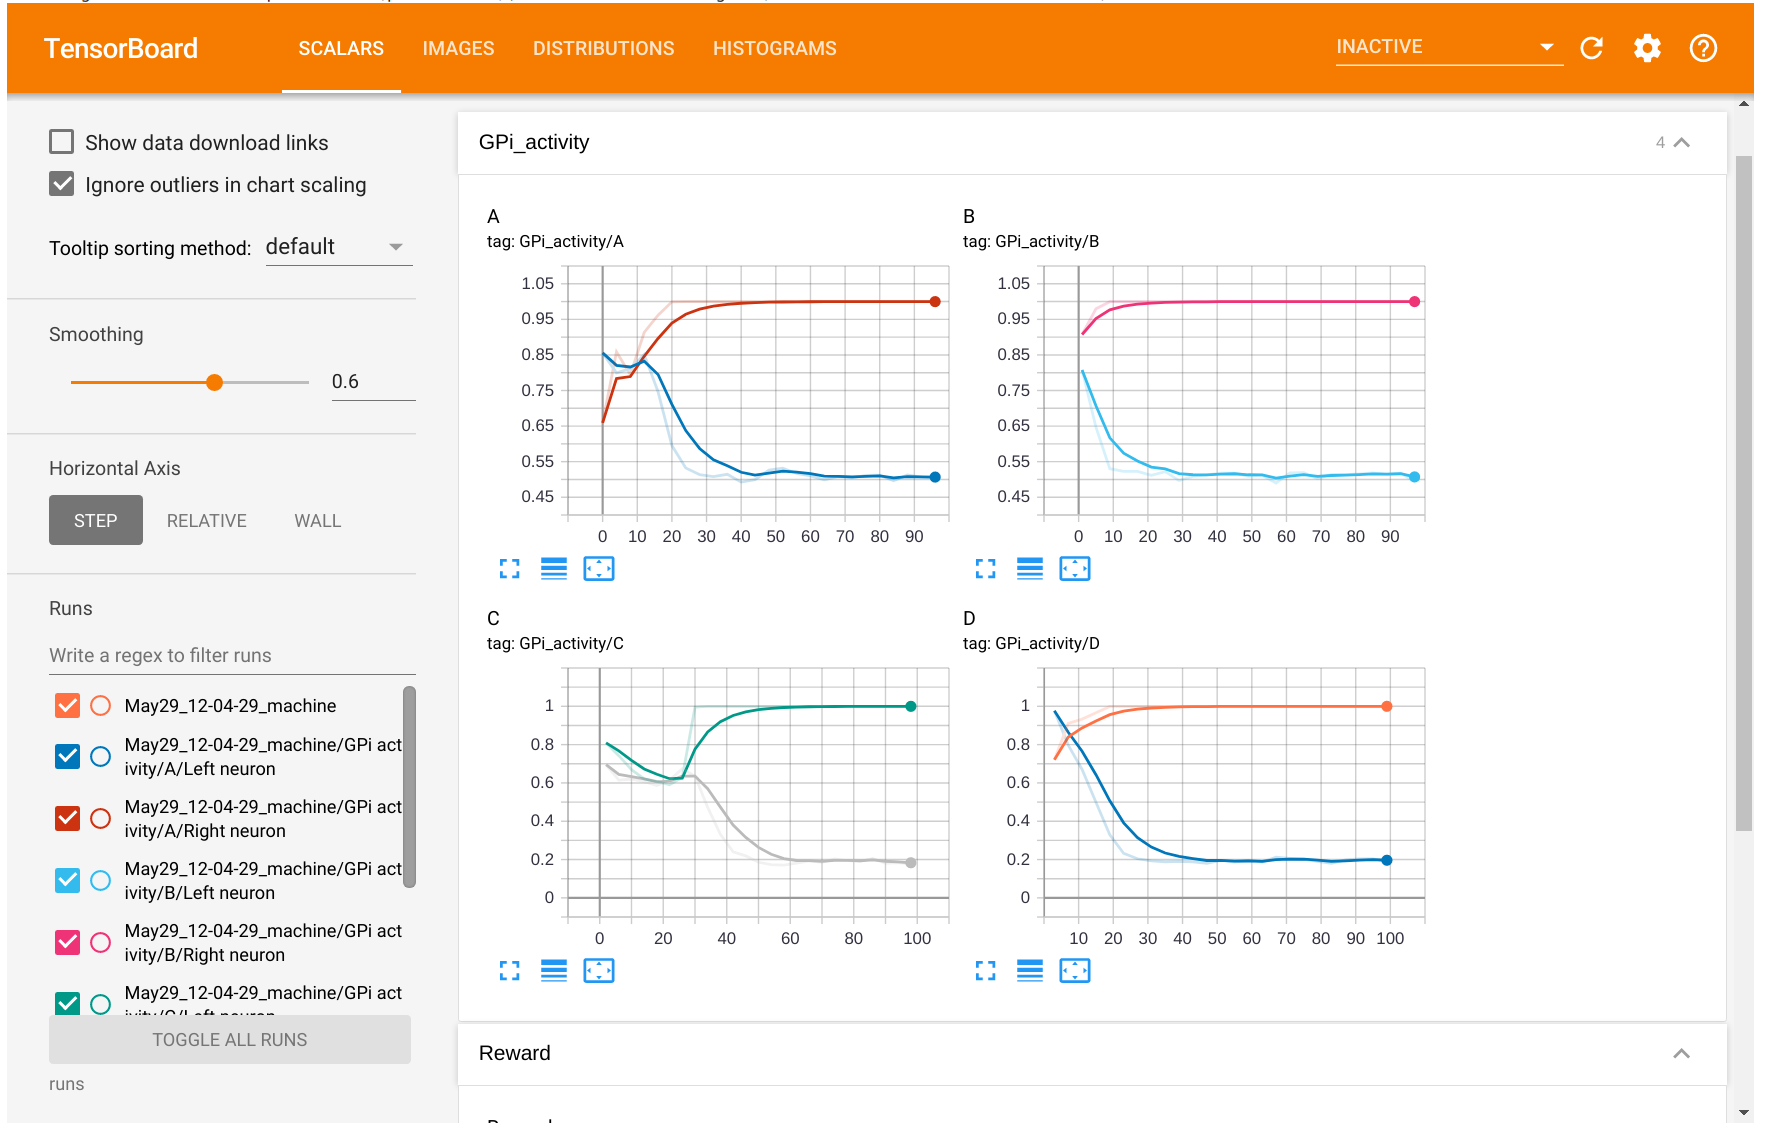{width=100%}

The Reward plot shows that the network successfully learns to solve the task, as it consistently gets rewards of +1 (note that this may vary from run to run, depending on weight initialization):

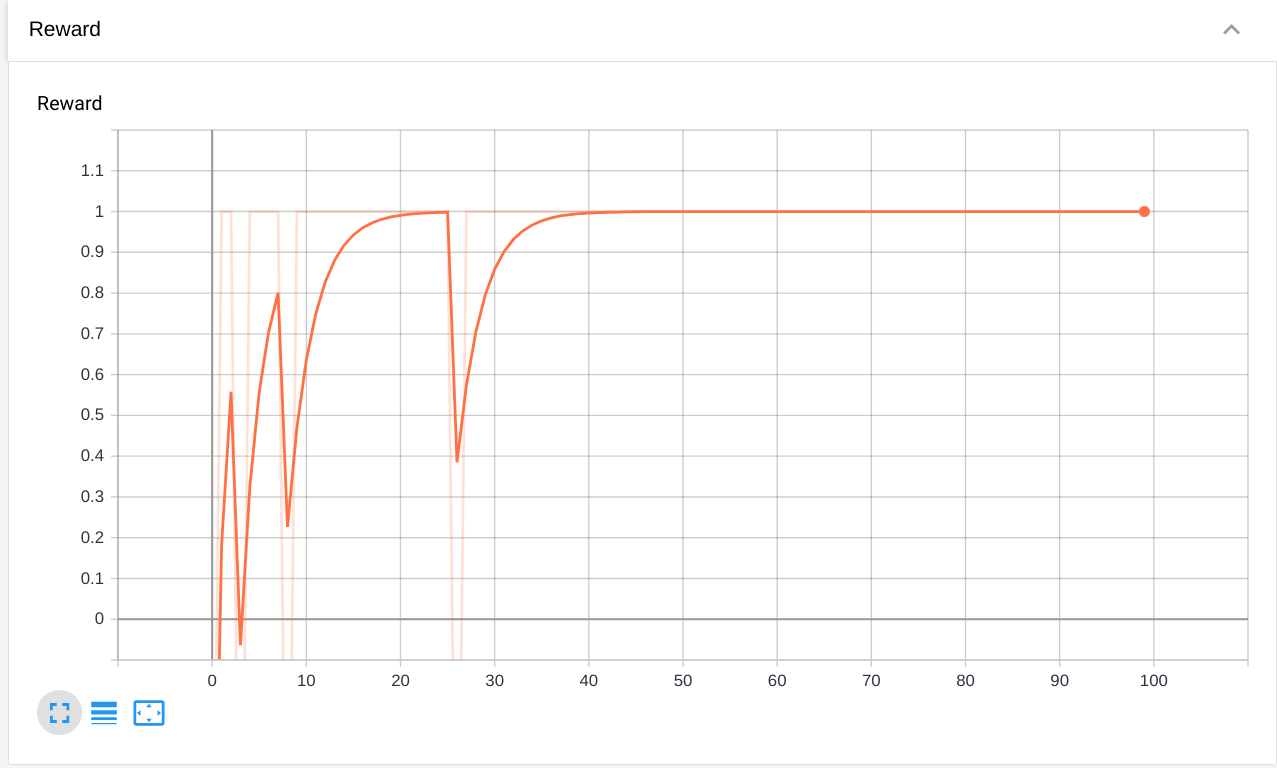{width=100%}

The GPi activity tab shows that the two GPi cells quickly learn to be inhibited for the right stimuli. 

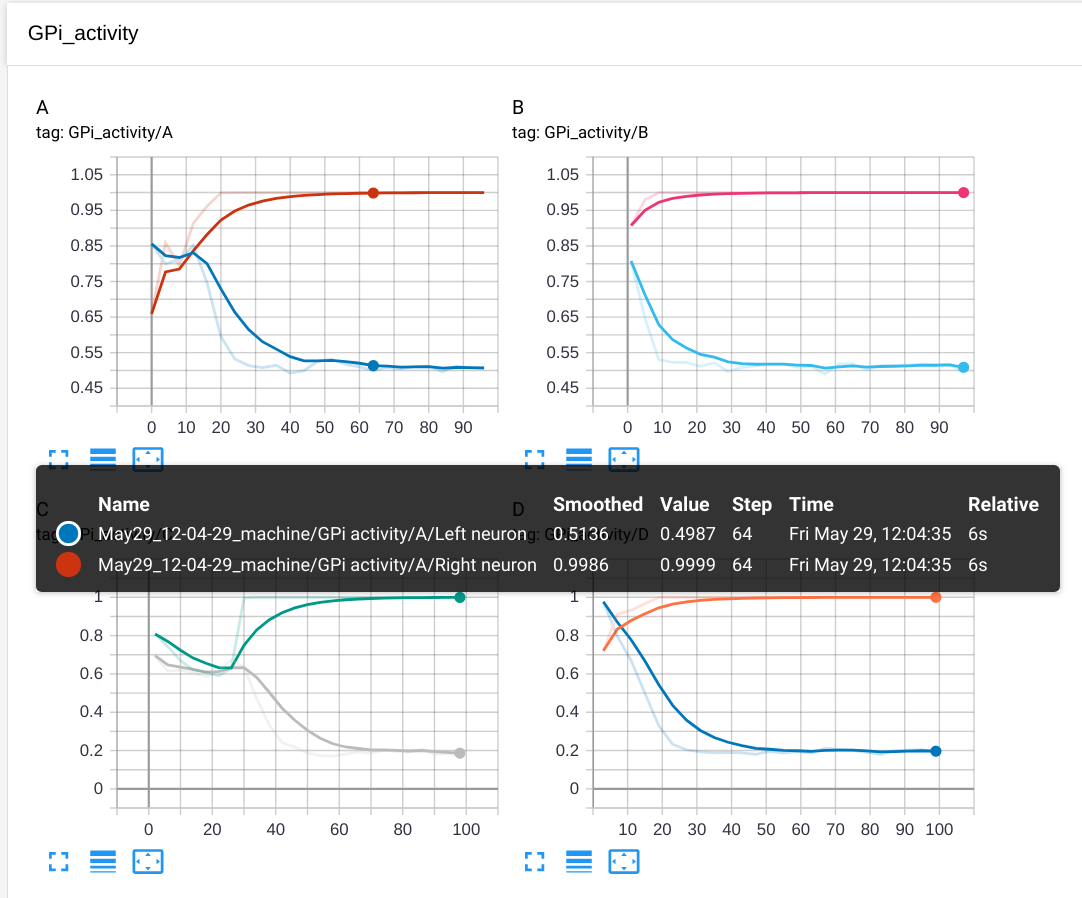{width=100%}

In the Images tab, the plot for the striatum allows to visualize activity at the end of each rtial, showing that only one cell in the correct subpopulation is active:

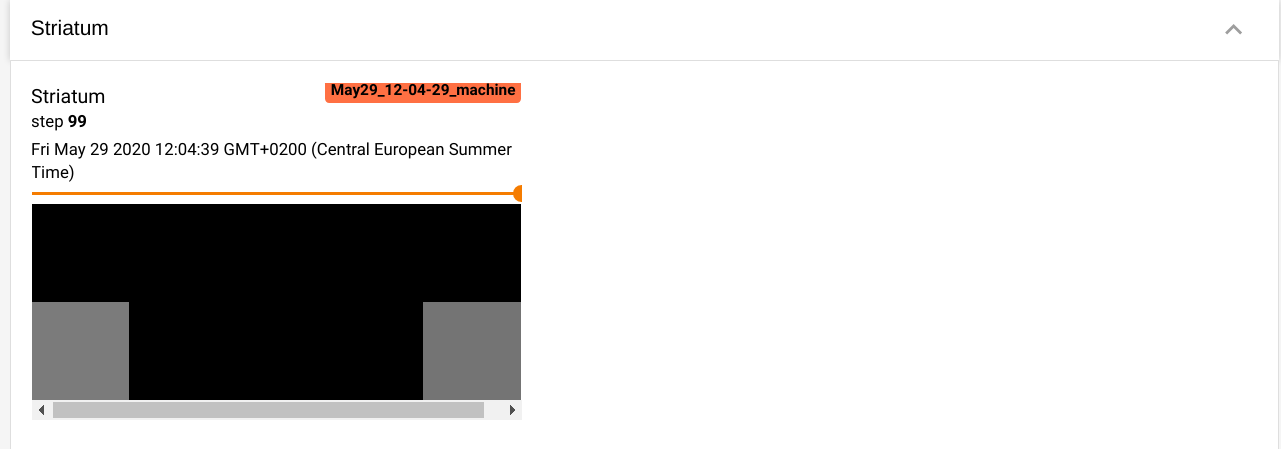{width=100%}

The matplotlib figure for the GPi activity shows what happens during a trial, especially at the end of the reset period:

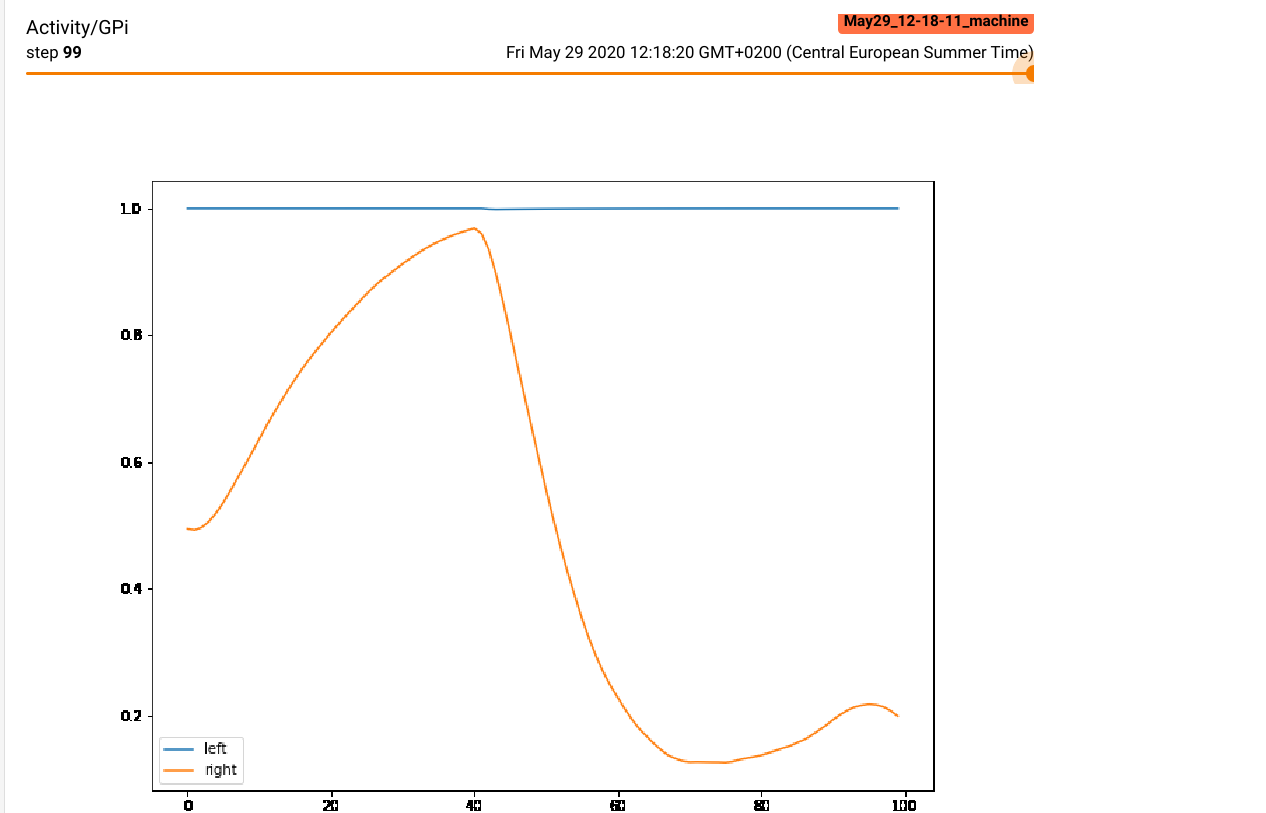{width=100%}

In the histograms tab, we can see that the left striatal population has acquired a preference (stronger weights) for the stimuli A and B, as the values are positive. The right population has negative values, so the neurons have stronger weights to the stimuli C and D. Note that some neurons in the right population still have stronger weights from A and B, but they are probably inhibited by the left population, so they do not impair performance.

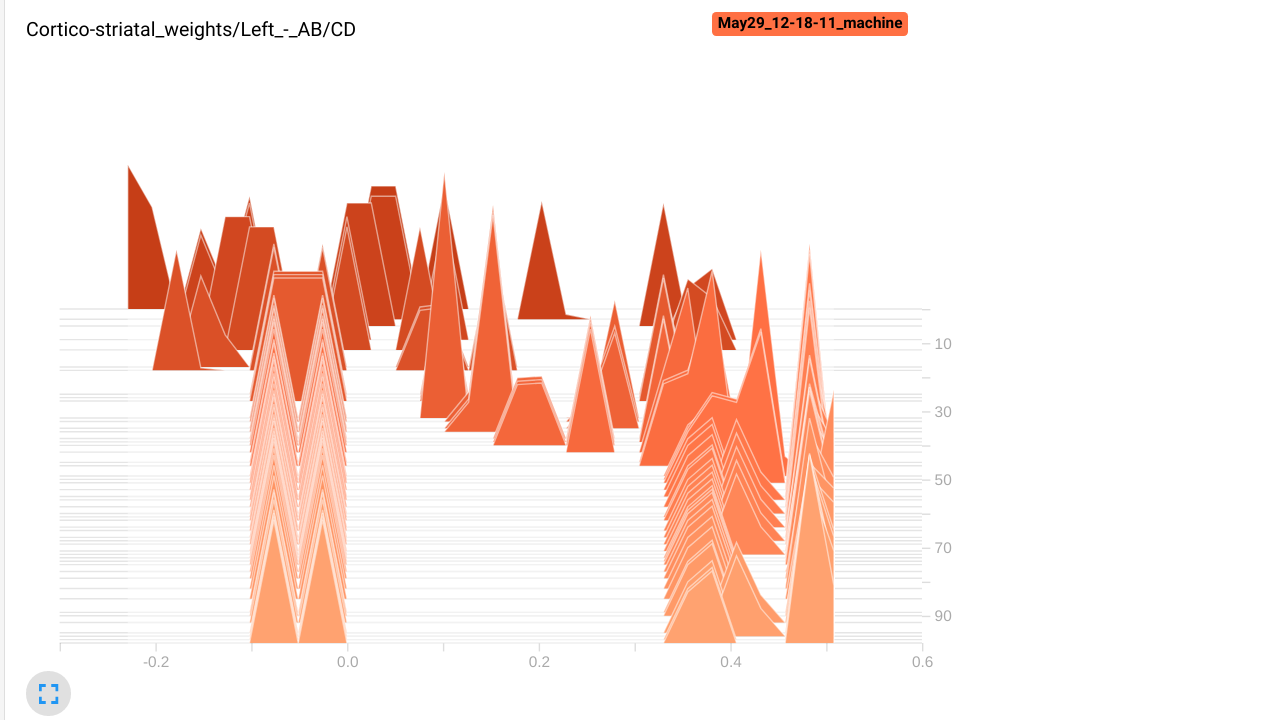{width=100%}

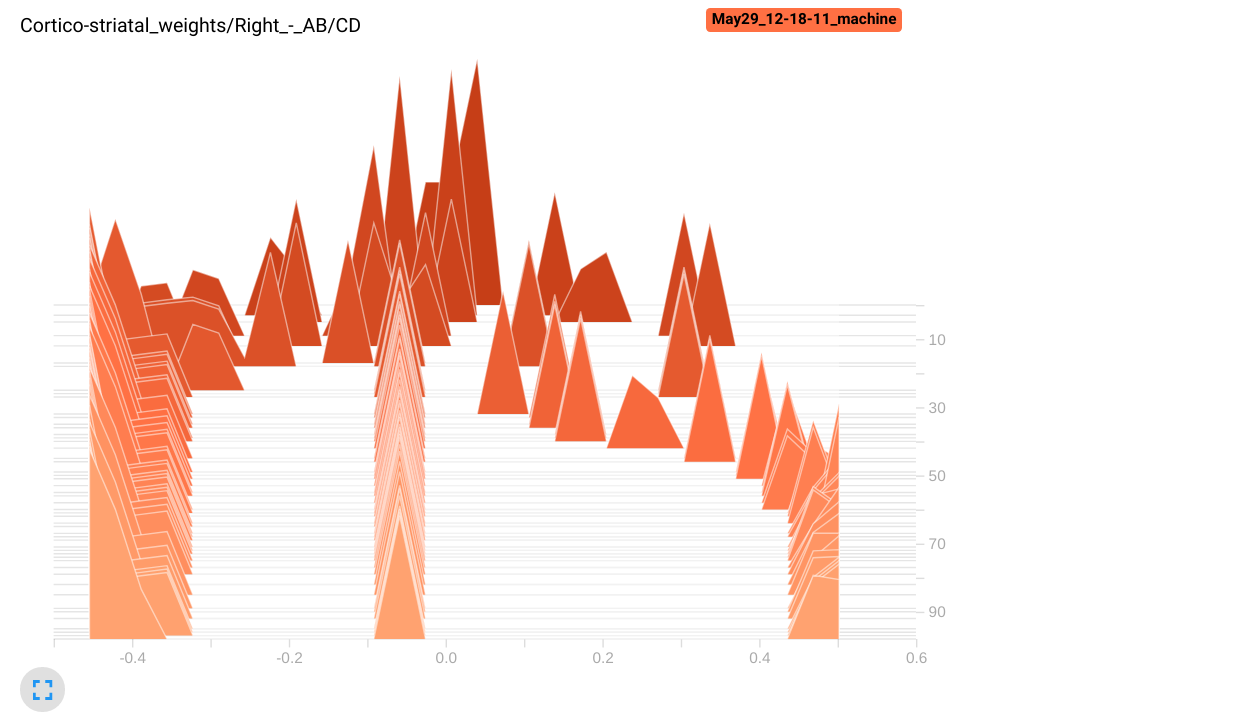{width=100%}